In [1]:
!pip install langdetect

# ==============================
# 1. Import Required Libraries
# ==============================

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack

from imblearn.over_sampling import SMOTE

from wordcloud import WordCloud
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=450b197bcd29e1063d67a94ef1c429fc5a3c04e7c3ee4d04735a154f693ffc0f
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
# 2. Load Dataset
# ==============================

df = pd.read_csv("netflix_reviews.csv")

# Basic checks
print("Dataset shape:", df.shape)
df.info()
df.head()

# Keep only relevant columns
df = df[['content', 'score', 'thumbsUpCount']]

print("\nNull values:\n", df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())

# Remove nulls and duplicates
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Remove very short reviews
df = df[df['content'].str.strip().str.len() > 5]

print("\nShape after cleaning:", df.shape)

Dataset shape: (57486, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57486 entries, 0 to 57485
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewId              57486 non-null  object 
 1   userName              57484 non-null  object 
 2   content               57479 non-null  object 
 3   score                 57485 non-null  float64
 4   thumbsUpCount         57485 non-null  float64
 5   reviewCreatedVersion  45556 non-null  object 
 6   at                    57485 non-null  object 
 7   appVersion            45556 non-null  object 
dtypes: float64(2), object(6)
memory usage: 3.5+ MB

Null values:
 content          7
score            1
thumbsUpCount    1
dtype: int64

Duplicate rows: 6456

Shape after cleaning: (50064, 3)


In [5]:
# 3. Filter English Reviews
# ==============================

def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

df = df[df['content'].apply(is_english)]

# ==============================

In [12]:
# 4. Sentiment Label Assignment
# ==============================

def assign_sentiment(score):
    if score >= 4:
        return 'positive'
    elif score == 3:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['score'].apply(assign_sentiment)

In [13]:
# 5. Text Preprocessing
# ==============================

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['cleaned_review'] = df['content'].apply(preprocess_text)

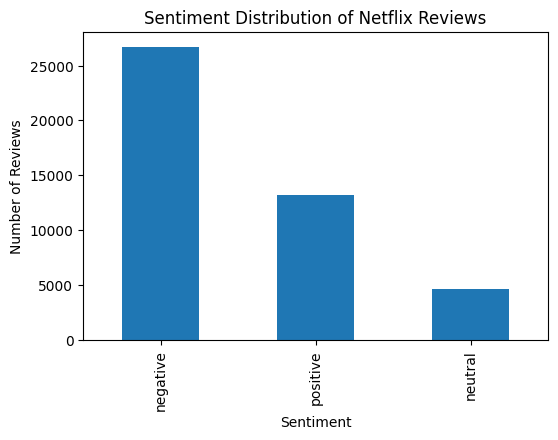

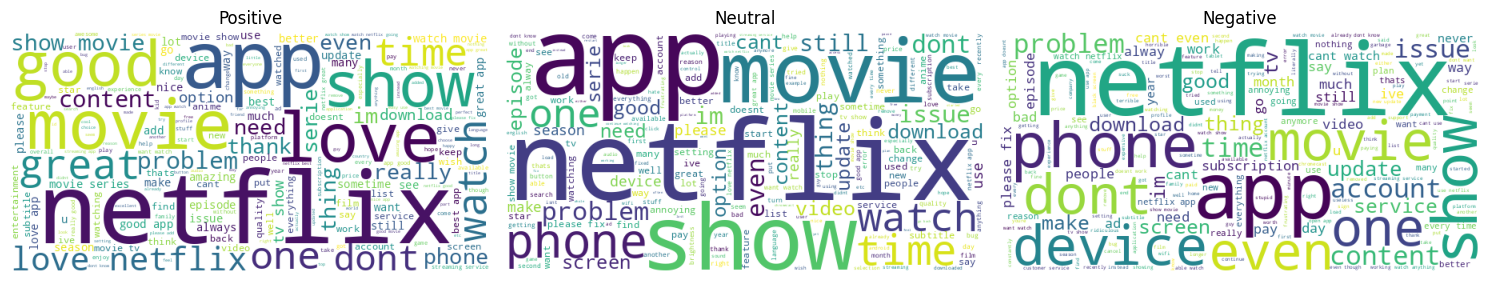

In [14]:
# 6. Exploratory Data Visualization (EDA)
# ==============================

# Sentiment distribution
plt.figure(figsize=(6,4))
df['sentiment'].value_counts().plot(kind='bar')
plt.title("Sentiment Distribution of Netflix Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

# Word clouds
sentiments = ['positive', 'neutral', 'negative']
plt.figure(figsize=(15,5))

for i, sentiment in enumerate(sentiments):
    text = " ".join(df[df['sentiment'] == sentiment]['cleaned_review'])
    wc = WordCloud(width=600, height=300, background_color='white').generate(text)
    plt.subplot(1,3,i+1)
    plt.imshow(wc)
    plt.title(sentiment.capitalize())
    plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
# 7. Bigram Analysis
# ==============================

for sentiment in sentiments:
    reviews = df[df['sentiment'] == sentiment]['cleaned_review']
    all_text = " ".join(reviews)

    vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')
    X_bi = vectorizer.fit_transform([all_text])

    if X_bi.shape[1] == 0:
        print(f"No bigrams for {sentiment}")
        continue

    bigram_counts = X_bi.toarray()[0]
    bigrams = vectorizer.get_feature_names_out()

    top_bigrams = pd.Series(bigram_counts, index=bigrams).sort_values(ascending=False).head(10)

    print(f"\nTop 10 Bigrams for {sentiment.capitalize()}:")
    print(top_bigrams)


Top 10 Bigrams for Positive:
love netflix         657
good app             484
great app            456
watch movie          442
movie series         417
love app             410
movie tv             328
best app             327
netflix app          239
streaming service    238
dtype: int64

Top 10 Bigrams for Neutral:
love netflix         143
good app             141
netflix app          134
want watch           131
movie series         125
watch movie          120
dont know            118
great app            116
watch netflix        100
continue watching     93
dtype: int64

Top 10 Bigrams for Negative:
netflix app          708
watch netflix        704
doesnt work          613
streaming service    612
watch movie          584
want watch           540
dont know            478
open app             446
customer service     444
use netflix          413
dtype: int64


In [16]:
# 8. TF-IDF Feature Extraction
# ==============================

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_text = tfidf.fit_transform(df['cleaned_review'])
y = df['sentiment']

# ==============================
# 9. CountVectorizer Comparison
# ==============================

count_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,2))
X_count = count_vectorizer.fit_transform(df['cleaned_review'])

print("TF-IDF shape:", X_text.shape)
print("CountVectorizer shape:", X_count.shape)

# ==============================
# 10. TF-IDF Experiments
# ==============================

tfidf_1000 = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
X_1000 = tfidf_1000.fit_transform(df['cleaned_review'])
print("TF-IDF (1000 features):", X_1000.shape)

tfidf_10000 = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_10000 = tfidf_10000.fit_transform(df['cleaned_review'])
print("TF-IDF (10000 features):", X_10000.shape)


TF-IDF shape: (44626, 5000)
CountVectorizer shape: (44626, 5000)
TF-IDF (1000 features): (44626, 1000)
TF-IDF (10000 features): (44626, 10000)


In [17]:
# 11. Add thumbsUpCount Feature
# ==============================

scaler = MinMaxScaler()
df['thumbsUp_scaled'] = scaler.fit_transform(df[['thumbsUpCount']])

thumbs_sparse = df[['thumbsUp_scaled']].values
X = hstack([X_text, thumbs_sparse])

print("Final feature shape:", X.shape)


Final feature shape: (44626, 5001)


In [18]:
# 12. Train-Test Split and SMOTE
# ==============================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nSentiment distribution after SMOTE:")
print(y_train_resampled.value_counts())



Sentiment distribution after SMOTE:
sentiment
negative    21388
neutral     21388
positive    21388
Name: count, dtype: int64


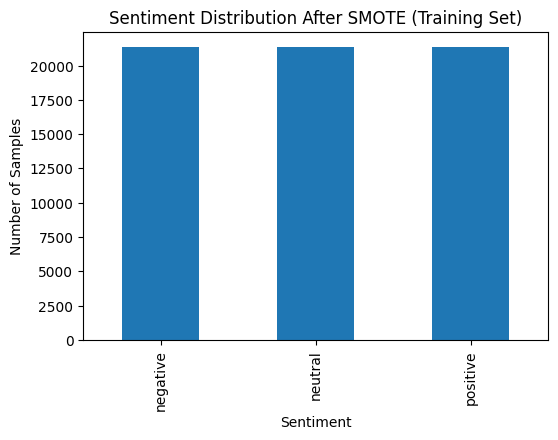

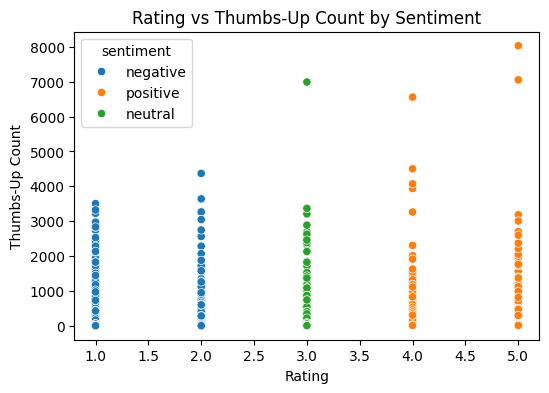

In [19]:
# 13. Result Visualizations
# ==============================

# Sentiment distribution after SMOTE
plt.figure(figsize=(6,4))
y_train_resampled.value_counts().plot(kind='bar')
plt.title("Sentiment Distribution After SMOTE (Training Set)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Samples")
plt.show()

# Scatter plot
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x='score', y='thumbsUpCount', hue='sentiment')
plt.title("Rating vs Thumbs-Up Count by Sentiment")
plt.xlabel("Rating")
plt.ylabel("Thumbs-Up Count")
plt.show()

In [20]:
# Please ensure this cell is executed to import all necessary evaluation metrics.
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [21]:
# Please execute this cell to define and train lr_model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000)

In [22]:
lr_preds = lr_model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_preds))
print(classification_report(y_test, lr_preds))

Logistic Regression Accuracy: 0.718126820524311
              precision    recall  f1-score   support

    negative       0.84      0.79      0.82      5348
     neutral       0.19      0.30      0.23       933
    positive       0.78      0.72      0.75      2645

    accuracy                           0.72      8926
   macro avg       0.60      0.60      0.60      8926
weighted avg       0.76      0.72      0.74      8926



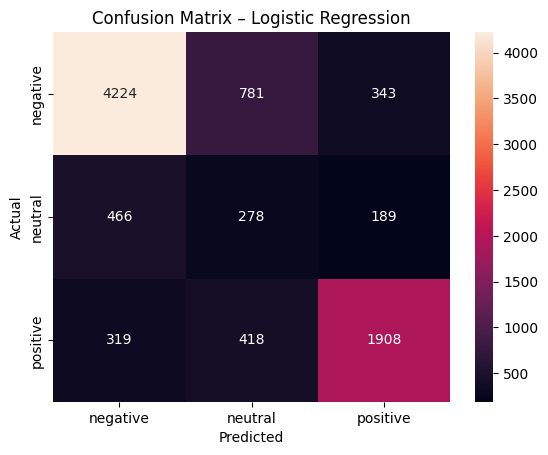

In [23]:
cm_lr = confusion_matrix(y_test, lr_preds)

plt.figure()
sns.heatmap(
    cm_lr,
    annot=True,
    fmt='d',
    xticklabels=lr_model.classes_,
    yticklabels=lr_model.classes_
)
plt.title('Confusion Matrix – Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [24]:
svm_model = LinearSVC()
svm_model.fit(X_train_resampled, y_train_resampled)

LinearSVC()

In [25]:
svm_preds = svm_model.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, svm_preds))
print(classification_report(y_test, svm_preds))

SVM Accuracy: 0.7027784001792516
              precision    recall  f1-score   support

    negative       0.83      0.78      0.80      5348
     neutral       0.18      0.29      0.22       933
    positive       0.76      0.70      0.73      2645

    accuracy                           0.70      8926
   macro avg       0.59      0.59      0.58      8926
weighted avg       0.74      0.70      0.72      8926



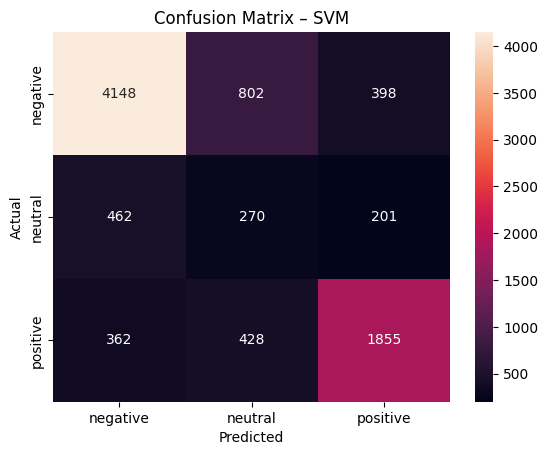

In [26]:
cm_svm = confusion_matrix(y_test, svm_preds)

plt.figure()
sns.heatmap(
    cm_svm,
    annot=True,
    fmt='d',
    xticklabels=svm_model.classes_,
    yticklabels=svm_model.classes_
)
plt.title('Confusion Matrix – SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


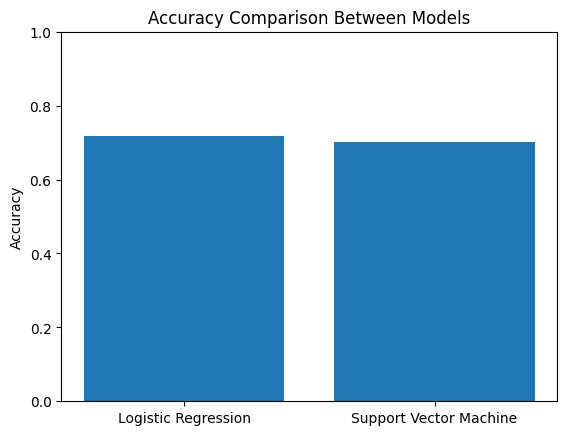

In [28]:


model_names = ['Logistic Regression', 'Support Vector Machine']
accuracies = [
    accuracy_score(y_test, lr_preds),
    accuracy_score(y_test, svm_preds)
]

plt.figure()
plt.bar(model_names, accuracies)
plt.title('Accuracy Comparison Between Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

In [30]:
!pip install gensim


from gensim.models import Word2Vec


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 89.9 MB/s eta 0:00:00


In [32]:
tokenized_reviews = df['cleaned_review'].apply(lambda x: x.split())

In [33]:
w2v_model = Word2Vec(
    sentences=tokenized_reviews,
    vector_size=100,   # embedding dimension
    window=5,
    min_count=5,
    workers=4,
    sg=1               # Skip-gram (better semantic quality)
)


In [35]:
def review_to_w2v(review):
    words = review.split()
    vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]

    if len(vectors) == 0:
        return np.zeros(100)

    return np.mean(vectors, axis=0)

X_w2v = np.vstack(df['cleaned_review'].apply(review_to_w2v))
y_w2v = df['sentiment']


In [36]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
    X_w2v,
    y_w2v,
    test_size=0.2,
    random_state=42,
    stratify=y_w2v
)


In [37]:
lr_w2v = LogisticRegression(max_iter=1000)
lr_w2v.fit(X_train_w2v, y_train_w2v)


LogisticRegression(max_iter=1000)

In [38]:
w2v_preds = lr_w2v.predict(X_test_w2v)

print("Word2Vec + Logistic Regression Accuracy:",
      accuracy_score(y_test_w2v, w2v_preds))

print(classification_report(y_test_w2v, w2v_preds))


Word2Vec + Logistic Regression Accuracy: 0.7815370826798118
              precision    recall  f1-score   support

    negative       0.78      0.95      0.85      5348
     neutral       0.44      0.02      0.03       933
    positive       0.80      0.72      0.76      2645

    accuracy                           0.78      8926
   macro avg       0.67      0.56      0.55      8926
weighted avg       0.75      0.78      0.74      8926



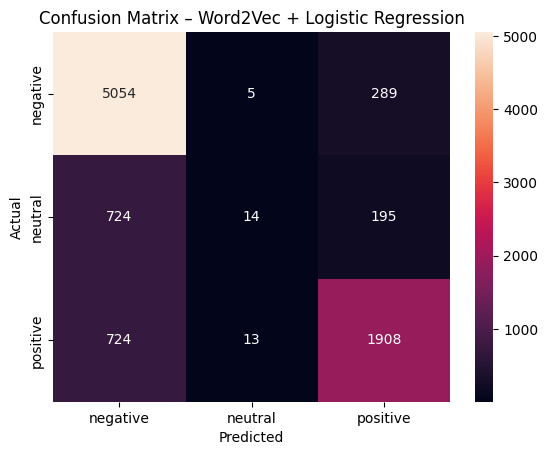

In [39]:
cm_w2v = confusion_matrix(y_test_w2v, w2v_preds)

plt.figure()
sns.heatmap(
    cm_w2v,
    annot=True,
    fmt='d',
    xticklabels=lr_w2v.classes_,
    yticklabels=lr_w2v.classes_
)
plt.title('Confusion Matrix – Word2Vec + Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


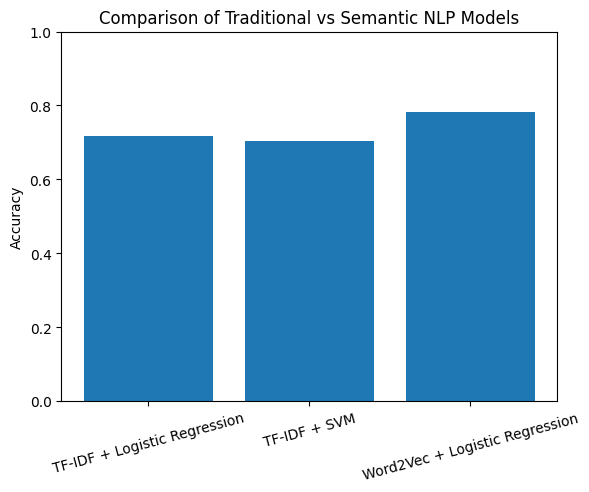

In [40]:
model_names = [
    'TF-IDF + Logistic Regression',
    'TF-IDF + SVM',
    'Word2Vec + Logistic Regression'
]

accuracies = [
    accuracy_score(y_test, lr_preds),
    accuracy_score(y_test, svm_preds),
    accuracy_score(y_test_w2v, w2v_preds)
]

plt.figure()
plt.bar(model_names, accuracies)
plt.title('Comparison of Traditional vs Semantic NLP Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.show()
